In [1904]:
from datetime import datetime as d

import numpy as np
from numpy import linalg
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import math as m
np.set_printoptions(precision=4, suppress=True)

import math

# Outline (As recommended by 538's 2016 Election Model)
_Link:_ https://fivethirtyeight.com/features/a-users-guide-to-fivethirtyeights-2016-general-election-forecast/

1) Collect, weight and average polls. 

2) Adjust polls for current trends and house effects.

3) Combine polls with demographic data through regression analysis to produce an electoral snapshot. 

_Sources:_
- https://github.com/davidasiegel/Nate_Silver_Presidential_Elections
- https://github.com/jseabold/538model/blob/master/silver_model.ipynb
    - Combined this with Ben Jones’ stuff
- https://github.com/jscottusf/election-dat
- https://github.com/benjones4747/silver/tree/5841d9a76ce78330c4ef701a3cc12a9e50097fdd/lib
    - Helpful with Step 1

## Step 1: Collect, Weight, and Average the Polls

#### Polls

In [1905]:
#gathers polls from 538
poll = pd.read_csv('Relevant_Data/2020/president_polls.csv')
poll.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,nationwide_batch,ranked_choice_reallocated,created_at,notes,url,stage,answer,candidate_name,candidate_party,pct
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Biden,Joseph R. Biden Jr.,DEM,46.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,False,False,4/6/20 06:09,NaN,https://www.unf.edu/uploadedFiles/aa/coas/porl...,general,Trump,Donald Trump,REP,40.0
2,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Biden,Joseph R. Biden Jr.,DEM,48.0
3,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,False,False,4/2/20 16:57,NaN,https://progressmichigan.org/wp-content/upload...,general,Trump,Donald Trump,REP,45.0
4,120899,65227,2020,Georgia,1549,Battleground Connect,NaN,NaN,Battleground Connect,NaN,...,False,False,4/3/20 11:04,NaN,https://projects.fivethirtyeight.com/polls/202...,general,Biden,Joseph R. Biden Jr.,DEM,46.0


#### Calculating Weighted Average (Recency, Pollster Rating, Sample Size)

In [1906]:
pollster_weights = pd.read_csv('2018_Pollster_Rating - Sheet1.csv')
pollster_weights.head(5)

,Pollster,# of Polls,NCPP / AAPOR / Roper,Exclusively Live Caller With Cellphones,Methodology,Banned by 538,Historical Advanced Plus-Minus,Predictive Plus-Minus,538 Grade,Mean-Reverted Bias,...,Simple Average Error,Simple Expected Error,Simple Plus-Minus,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect
0,Selzer & Co.,43,yes,yes,Live,no,-1.9,-1.4,A+,R +0.0,...,4.2,5.6,-1.4,-1.9,-1.1,-1.4,30,R +0.0,R +0.0,D +0.1
1,Monmouth University,95,yes,yes,Live,no,-1.5,-1.3,A+,D +1.4,...,5.3,6.2,-0.8,-1.5,-1.1,-1.3,65,D +2.1,D +1.4,R +0.7
2,Field Research Corp. (Field Poll),25,yes,yes,Live,no,-2.5,-1.1,A+,R +1.2,...,3.9,5.7,-1.8,-2.5,-1.1,-1.1,18,R +3.3,R +1.2,D +0.6
3,ABC News/Washington Post,60,yes,yes,Live,no,-1.3,-1.1,A+,D +0.6,...,2.9,4.6,-1.8,-1.3,-0.9,-1.1,55,D +0.9,D +0.6,D +1.5
4,Elway Research,21,yes,yes,Live,no,-2.2,-1.1,A+,D +0.5,...,3.9,5.9,-1.9,-2.2,-0.9,-1.1,20,D +1.2,D +0.5,D +3.2


In [1907]:
#HELPER FUNCTION 
def month(value):
    return value[0]

def year(value):
    return value[-2:]

In [1908]:
polls = pd.merge(poll, pollster_weights, left_on = "pollster", right_on = "Pollster")
#for i in polls.columns:
    #print(i)

In [1909]:
# Recency (most recent: 4/5/20)
# Need to use exponential decay to compare the polling time to the election date
# Caveat: Being farther out from election day makes polls kind of useless
# Our code predicts if the elections were to happen on April 5th, 2020

def exp_decay(days):
    days = getattr(days, "days", days)
    return .5 ** (days/30.)

def ageweight(raw):
    raw['age_weight'] = 0.0
    for index, row in raw.iterrows():
        d0 = ('4/5/20')
        d0 = d.strptime(d0, '%m/%d/%y')
        date = row['end_date']
        d1 = d.strptime(date, '%m/%d/%y')
        delta = d0 - d1
        diff = delta.days
        age_weight = exp_decay(diff)
        raw.at[index,'recency_weight'] = age_weight
    return

ageweight(polls)

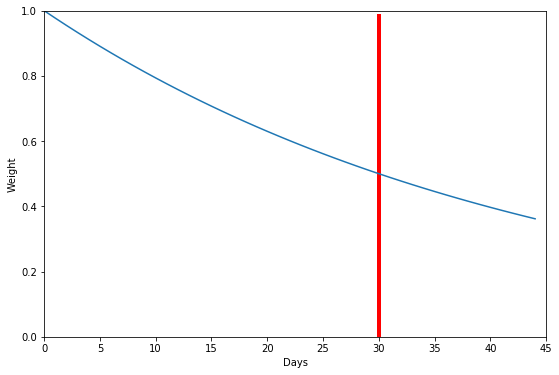

In [1910]:
fig, ax = plt.subplots(figsize=(9,6), subplot_kw={"xlabel" : "Days",
                                                   "ylabel" : "Weight"})
days = np.arange(0, 45)
ax.plot(days, exp_decay(days));
ax.vlines(30, 0, .99, color='r', linewidth=4)
ax.set_ylim(0,1)
ax.set_xlim(0, 45);

In [1911]:
polls[['end_date','recency_weight']]

,end_date,recency_weight
0,4/4/20,0.977160
1,4/4/20,0.977160
2,2/18/20,0.337587
3,2/18/20,0.337587
4,2/18/20,0.337587
...,...,...
2862,1/21/19,0.000038
2863,1/21/19,0.000038
2864,1/21/19,0.000038
2865,1/21/19,0.000038


In [1912]:
# Pollster Rating
def weight(x):
    #i think this weight i based on the 2016 elections
    newx = float(1 - (1/(3.025044 + 1.200763)) * (x + 1.200763))
    return newx

def apply_weights(pr):
    pr['pollster_weight'] = 0.0
    for index, row in pr.iterrows():
        x = row['Predictive Plus-Minus']
        if row['Banned by 538'] == 'yes':
            newx = 0.0
        else:
            newx = weight(x)
        pr.at[index,'pollster_weight'] = newx
    return pr

In [1913]:
apply_weights(polls)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Advanced Plus-Minus,Mean-Reverted Advanced Plus Minus,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
3,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-1.0,-0.2,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,92872,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,-4.7,-0.4,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529
2863,92873,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,-4.7,-0.4,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529
2864,92873,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,-4.7,-0.4,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529
2865,92874,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,-4.7,-0.4,0.5,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529


In [1914]:
# Sample size (based on how Nate Silver used it in 2008)
mean = np.mean(polls['sample_size'])
polls['sample_size_weight'] = (polls['sample_size']/mean)**2
polls[['sample_size', 'sample_size_weight']]

,sample_size,sample_size_weight
0,3244.0,4.377505
1,3244.0,4.377505
2,672.0,0.187847
3,672.0,0.187847
4,668.0,0.185617
...,...,...
2862,593.0,0.146276
2863,593.0,0.146276
2864,593.0,0.146276
2865,593.0,0.146276


In [1915]:
# Get weighted averages
polls['weighted_average'] = polls['recency_weight'] * polls['pollster_weight'] * polls['sample_size_weight']

def weighted_average(df):
    weights1 = df['recency_weight']
    weights2 = df['pollster_weight']
    weights3 = df['sample_size_weight']
    return weights1*weights2*weights3
    
state_polls = polls.groupby(['state', 'pollster']).apply(weighted_average)

In [1916]:
polls.head(5)

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Predictive Plus-Minus,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398
3,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,-0.4,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.185617,0.050788


In [1917]:
polls['state'].unique()

array(['Florida', 'Michigan', 'California', 'Wisconsin', 'Kansas',
       'Maine', 'Arizona', 'Iowa', 'Washington', 'Maine CD-1',
       'Maine CD-2', 'Ohio', 'North Carolina', nan, 'Texas',
       'Pennsylvania', 'South Carolina', 'New York', 'New Mexico',
       'New Hampshire', 'Nevada', 'Colorado', 'Massachusetts', 'Georgia',
       'North Dakota', 'Minnesota', 'Mississippi', 'Alabama', 'Tennessee',
       'Virginia', 'Missouri', 'New Jersey', 'Oklahoma', 'Delaware',
       'Alaska', 'Kentucky', 'Utah'], dtype=object)

In [1918]:
rep_points = []
dem_points = []
for i in polls['state'].unique():
    start = polls[polls['state'] == i]
    for j in start['pollster'].unique():
        mid = start[start['pollster'] == j]
        mid = mid.sort_values(by = 'end_date').reset_index(drop=True)
        rep = mid[mid['candidate_party'] == 'REP'].reset_index(drop=True)
        dem = mid[mid['candidate_party'] == 'DEM'].reset_index(drop=True)
        rep_points.append([i,j,(rep.loc[0]['pct'] - rep.loc[len(rep)-1]['pct']*(-1))])
        dem_points.append([i,j,(dem.loc[0]['pct'] - dem.loc[len(dem)-1]['pct'])])

In [1919]:
loess_df_1 = polls.copy()
loess_df_1['spread'] = "NAN " + str(0)

for i in rep_points: 
    loess_df_1.loc[(loess_df_1.state == i[0]) & (loess_df_1['pollster'] == i[1]),'spread'] = ("REP " + str(i[2]))
    
for i in dem_points: 
    loess_df_1.loc[(loess_df_1.state == i[0]) & (loess_df_1['pollster'] == i[1]),'spread'] = ("DEM " + str(i[2]))

polls = loess_df_1.reset_index(drop=True)
polls

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,# of Polls for Bias Analysis,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average,spread
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960,DEM 3.0
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960,DEM 3.0
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398,DEM 3.0
3,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398,DEM 3.0
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,4,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.185617,0.050788,DEM 3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2862,92872,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.146276,0.000003,DEM 5.899999999999999
2863,92873,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.146276,0.000003,DEM 5.899999999999999
2864,92873,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.146276,0.000003,DEM 5.899999999999999
2865,92874,57407,2020,New Hampshire,1304,Praecones Analytica,645,New Hampshire Journal,Praecones Analytica,257.0,...,3,R +1.8,R +0.2,R +5.3,0.0,0.000038,0.597529,0.146276,0.000003,DEM 5.899999999999999


## Step 2: Adjust polls

* Trend line adjustment 
* House effects adjustment

In [1920]:
pvi = pd.read_csv("Relevant_Data/2020/fivethirtyeight_partisan_lean_STATES copy.csv")
pvi.head()

,state,pvi_538
0,Alabama,R+27
1,Alaska,R+15
2,Arizona,R+9
3,Arkansas,R+24
4,California,D+24


In [1921]:
pvi.set_index("state", inplace=True);
pvi.head()

,pvi_538
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [1922]:
pvi.columns = ['PVI']
pvi.head()

,PVI
state,
Alabama,R+27
Alaska,R+15
Arizona,R+9
Arkansas,R+24
California,D+24


In [1923]:
pvi.PVI = pvi.PVI.replace({"EVEN" : "0"})
pvi.PVI = pvi.PVI.str.replace("R\+", "-")
pvi.PVI = pvi.PVI.str.replace("D\+", "")
pvi.PVI = pvi.PVI.astype(float)
pvi.PVI

state
Alabama          -27.0
Alaska           -15.0
Arizona           -9.0
Arkansas         -24.0
California        24.0
Colorado           1.0
Connecticut       11.0
Delaware          14.0
Florida           -5.0
Georgia          -12.0
Hawaii            36.0
Idaho            -35.0
Illinois          13.0
Indiana          -18.0
Iowa              -6.0
Kansas           -23.0
Kentucky         -23.0
Louisiana        -17.0
Maine              5.0
Maryland          23.0
Massachusetts     29.0
Michigan           1.0
Minnesota          2.0
Mississippi      -15.0
Missouri         -19.0
Montana          -18.0
Nebraska         -24.0
Nevada            -1.0
New Hampshire     -2.0
New Jersey        13.0
New Mexico         7.0
New York          22.0
North Carolina    -5.0
North Dakota     -33.0
Ohio              -7.0
Oklahoma         -34.0
Oregon             9.0
Pennsylvania      -1.0
Rhode Island      26.0
South Carolina   -17.0
South Dakota     -31.0
Tennessee        -28.0
Texas            -17.0
Utah 

In [1924]:
party_affil = pd.read_csv("party_affiliation_by_state.csv")
party_affil =party_affil.rename(columns={'Unnamed: 0': "State", 'Democrat/Lean Democratic': 'Democrat', 
                           'Republican/Lean Republican': 'Republican', 
                            'Democratic advantage':'Dem_Adv'}).set_index("State")[1:53]
party_affil

,Democrat,Republican,Dem_Adv,N,Classification
State,,,,,
U.S.,45,38,7,"180,106",Lean Dem
Maine,47,39,8,941,Lean Dem
New Hampshire,43,40,3,831,Competitive
Vermont,52,30,22,496,Solid Dem
Massachusetts,57,26,31,"3,805",Solid Dem
Rhode Island,48,27,21,602,Solid Dem
Connecticut,51,32,19,"2,020",Solid Dem
New York,52,29,23,"10,864",Solid Dem
New Jersey,48,33,15,"4,455",Solid Dem


In [1925]:
party_affil.columns

Index(['Democrat', 'Republican', 'Dem_Adv', 'N', 'Classification'], dtype='object')

In [1926]:
party_affil['Democrat'] = party_affil.Democrat.str.replace("%", "").astype(float)
party_affil.Republican = party_affil.Republican.str.replace("%", "").astype(float)
party_affil["no_party"] = 100 - party_affil.Democrat - party_affil.Republican
party_affil

,Democrat,Republican,Dem_Adv,N,Classification,no_party
State,,,,,,
U.S.,45.0,38.0,7,"180,106",Lean Dem,17.0
Maine,47.0,39.0,8,941,Lean Dem,14.0
New Hampshire,43.0,40.0,3,831,Competitive,17.0
Vermont,52.0,30.0,22,496,Solid Dem,18.0
Massachusetts,57.0,26.0,31,"3,805",Solid Dem,17.0
Rhode Island,48.0,27.0,21,602,Solid Dem,25.0
Connecticut,51.0,32.0,19,"2,020",Solid Dem,17.0
New York,52.0,29.0,23,"10,864",Solid Dem,19.0
New Jersey,48.0,33.0,15,"4,455",Solid Dem,19.0


In [1927]:
#Census
census_data = pd.read_csv("Census_Data.csv")
census_data.head()

,State,Total_Pop_2019,Under_18,Over_65,Black,Native American,Hispanic,Non-Hispanic,High_School_Grad,Bachelor_Degree,Per_Capita_Income,Median_Household_Income_2018,Pop_Per_Sq_Mile_2010
0,Alabama,"4,903,185",22.30%,16.90%,26.80%,0.70%,4.40%,65.40%,85.80%,24.90%,"$26,846","$48,486",94.4
1,Alaska,"731,545",24.90%,11.80%,3.80%,15.40%,7.20%,60.30%,92.70%,29.20%,"$35,874","$76,715",1.2
2,Arizona,"7,278,717",22.90%,17.50%,5.10%,5.30%,31.60%,54.40%,86.80%,28.90%,"$29,265","$56,213",56.3
3,Arkansas,"3,017,804",23.30%,17.00%,15.70%,1.00%,7.70%,72.20%,86.20%,22.60%,"$25,635","$45,726",56
4,California,"39,512,223",22.70%,14.30%,6.50%,1.60%,39.30%,36.80%,82.90%,33.30%,"$35,021","$71,228",239.1


In [1928]:
census_refined = pd.DataFrame({})

census_data.rename(columns={
                        "Median_Household_Income_2018" : "median_income",
                        "Per_Capita_Income" : "average_income",
                        "Pop_Per_Sq_Mile_2010" : "pop_density",
                        "High_School_Grad" : "educ_hs",
                        "Bachelor_Degree" : "educ_coll",
                        "Non-Hispanic " : "per_white",
                        "Hispanic" : "per_hisp",
                        "State" : "state",
                        "Black" : "per_black",
                                }, inplace=True)

census_data.head(5)

,state,Total_Pop_2019,Under_18,Over_65,per_black,Native American,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density
0,Alabama,"4,903,185",22.30%,16.90%,26.80%,0.70%,4.40%,65.40%,85.80%,24.90%,"$26,846","$48,486",94.4
1,Alaska,"731,545",24.90%,11.80%,3.80%,15.40%,7.20%,60.30%,92.70%,29.20%,"$35,874","$76,715",1.2
2,Arizona,"7,278,717",22.90%,17.50%,5.10%,5.30%,31.60%,54.40%,86.80%,28.90%,"$29,265","$56,213",56.3
3,Arkansas,"3,017,804",23.30%,17.00%,15.70%,1.00%,7.70%,72.20%,86.20%,22.60%,"$25,635","$45,726",56
4,California,"39,512,223",22.70%,14.30%,6.50%,1.60%,39.30%,36.80%,82.90%,33.30%,"$35,021","$71,228",239.1


In [1929]:
tot_pop = census_data["Total_Pop_2019"].str.replace(",","").astype(float)
per_18 = census_data["Under_18"].str.strip('%').astype(float)/100 # under 18
per_65 = census_data["Over_65"].str.strip('%').astype(float)/100 # over 65
older_pop = per_65*tot_pop
vote_pop = tot_pop - per_18*tot_pop - older_pop
census_data["vote_pop"] = vote_pop
census_data["older_pop"] = older_pop
census_data["per_older"] = older_pop / tot_pop
census_data["per_vote"] = vote_pop / tot_pop


del census_data["Total_Pop_2019"]
del census_data["Under_18"]
del census_data["Over_65"]
del census_data["Native American"]

In [1930]:
columns = ['per_black', 'per_hisp', 'per_white', 'educ_hs', 'educ_coll']
columns_1 = ['average_income', 'median_income']

for i in columns:
    census_data[i] = census_data[i].str.strip('%').astype(float)
    
for i in columns_1:
    census_data[i] = census_data[i].str.strip('$')
    census_data[i] = census_data[i].str.replace(',','').astype(float)

In [1931]:
census_data.head()

,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
0,Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608
1,Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633
2,Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596
3,Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597
4,California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630


In [1932]:
census_data.set_index("state", inplace=True)

In [1933]:
census_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote
state,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630


In [1934]:
states_abbrev_dict = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [1935]:
#Campaign Contributions

trump_contributions = pd.read_csv('Trump_Contributions.csv')
trump_contributions = trump_contributions[['state','amount']]
trump_give = trump_contributions.groupby('state').sum()
trump_give.head()

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,amount
state,
AK,207571.54
AL,771455.87
AR,356147.43
AZ,1713691.27
CA,9474707.89


In [1936]:
biden_contributions = pd.read_csv('Biden_Contributions.csv')
biden_contributions = biden_contributions[['state','amount']]
biden_give = biden_contributions.groupby('state').sum()
biden_give.head()

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,amount
state,
AK,38290.30
AL,206558.37
AR,72624.75
AZ,287279.67
CA,7670810.88


In [1937]:
biden_give = biden_give.reset_index()
biden_give['state'] = biden_give.state.replace(states_abbrev_dict)

trump_give = trump_give.reset_index()
trump_give['state'] = trump_give.state.replace(states_abbrev_dict)

biden_give.set_index("state", inplace=True)
trump_give.set_index("state", inplace=True);

In [1938]:
demo_data = census_data.join(party_affil[["Dem_Adv", "no_party"]]).join(pvi)
demo_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI
state,,,,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15,15.0,-27.0
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21,17.0,-15.0
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2,18.0,-9.0
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597,-9,19.0,-24.0
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21,19.0,24.0


In [1939]:
demo_data = demo_data.join(biden_give, on='state')
demo_data = demo_data.join(trump_give, on='state', rsuffix = '_trump')
demo_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI,amount,amount_trump
state,,,,,,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15,15.0,-27.0,206558.37,771455.87
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21,17.0,-15.0,38290.30,207571.54
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2,18.0,-9.0,287279.67,1713691.27
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56,1.801629e+06,513026.680,0.170,0.597,-9,19.0,-24.0,72624.75,356147.43
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21,19.0,24.0,7670810.88,9474707.89


In [1940]:
giving = demo_data[["amount", "amount_trump"]].div(demo_data[["vote_pop", "older_pop"]].sum(1), axis=0)
giving.head()

,amount,amount_trump
state,,
Alabama,0.054218,0.202494
Alaska,0.069696,0.377822
Arizona,0.051191,0.305368
Arkansas,0.031376,0.153866
California,0.251148,0.310209


In [1941]:
demo_data[["amount", "amount_trump"]] = giving

In [1942]:
#pop_density
#Dem_adv
demo_data['pop_density'] = demo_data['pop_density'].str.replace(',','').astype(float)
demo_data['Dem_Adv'] = demo_data['Dem_Adv'].astype(float)
demo_data = demo_data.drop('District of Columbia', axis = 0)
demo_data.head()

,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI,amount,amount_trump
state,,,,,,,,,,,,,,,,,
Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15.0,15.0,-27.0,0.054218,0.202494
Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21.0,17.0,-15.0,0.069696,0.377822
Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2.0,18.0,-9.0,0.051191,0.305368
Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56.0,1.801629e+06,513026.680,0.170,0.597,-9.0,19.0,-24.0,0.031376,0.153866
California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21.0,19.0,24.0,0.251148,0.310209


In [1943]:
from scipy import cluster as sp_cluster
from sklearn import cluster, neighbors

In [1944]:
clean_data = sp_cluster.vq.whiten(demo_data.values)

In [1945]:
clean_data.var(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [1946]:
KNN = neighbors.NearestNeighbors(n_neighbors=7)
KNN.fit(clean_data)
KNN.kneighbors(clean_data[0].reshape(1,-1), return_distance=True)

(array([[0.    , 1.283 , 1.8028, 2.0372, 2.3057, 2.4864, 2.4938]]),
 array([[ 0, 39, 17, 41, 23, 16,  3]]))

In [1947]:
demo_data.index[0], demo_data.index[KNN.kneighbors(clean_data[0].reshape(1,-1), return_distance=True)[1][0]]

('Alabama',
 Index(['Alabama', 'South Carolina', 'Louisiana', 'Tennessee', 'Mississippi',
        'Kentucky', 'Arkansas'],
       dtype='object', name='state'))

In [1948]:
nearest_neighbor = {}
for i, state in enumerate(demo_data.index):
    neighborhood = KNN.kneighbors(clean_data[i].reshape(1,-1), return_distance=True)
    nearest_neighbor.update({state : (demo_data.index[neighborhood[1]],
                                     neighborhood[0])})

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Support for multi-dimensional indexing (e.g. `index[:, None]`) on an Index is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  after removing the cwd from sys.path.
/Users/siddhipatel/

In [1949]:
nearest_neighbor

{'Alabama': (array([['Alabama', 'South Carolina', 'Louisiana', 'Tennessee',
          'Mississippi', 'Kentucky', 'Arkansas']], dtype=object),
  array([[0.    , 1.283 , 1.8028, 2.0372, 2.3057, 2.4864, 2.4938]])),
 'Alaska': (array([['Alaska', 'North Dakota', 'Colorado', 'Kansas', 'Washington',
          'Utah', 'Minnesota']], dtype=object),
  array([[0.    , 3.4494, 3.9084, 4.0897, 4.1378, 4.1787, 4.3093]])),
 'Arizona': (array([['Arizona', 'Nevada', 'New Mexico', 'Oklahoma', 'Kansas',
          'North Carolina', 'Indiana']], dtype=object),
  array([[0.    , 2.9175, 2.9629, 3.2068, 3.4608, 3.489 , 3.522 ]])),
 'Arkansas': (array([['Arkansas', 'Tennessee', 'Oklahoma', 'Alabama', 'South Carolina',
          'Missouri', 'Indiana']], dtype=object),
  array([[0.    , 2.1176, 2.1767, 2.4938, 2.5191, 2.5666, 2.6562]])),
 'California': (array([['California', 'Texas', 'New York', 'Florida', 'Illinois',
          'Virginia', 'Washington']], dtype=object),
  array([[0.    , 4.4746, 4.896 , 6.0694,

In [1950]:
k_means = cluster.KMeans(n_clusters=5, n_init=50)
k_means.fit(clean_data)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
labels

array([2, 0, 2, 2, 4, 1, 1, 1, 4, 2, 1, 0, 1, 2, 0, 0, 2, 2, 0, 1, 3, 2,
       0, 2, 2, 0, 0, 2, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0, 1, 2, 0, 2, 4, 0,
       0, 1, 1, 2, 0, 0], dtype=int32)

In [1951]:
clusters = sp_cluster.vq.kmeans(clean_data, 5)[0]
clusters

array([[ 1.9636,  0.5707,  4.5368, 31.3099,  5.0903,  6.143 ,  5.1521,
         0.5178,  0.8315,  0.9148,  8.8817, 47.8571, -0.3299,  7.2973,
        -0.94  ,  0.332 ,  0.1236],
       [ 1.5072,  1.3267,  3.6636, 32.3227,  7.2353,  8.4903,  7.5999,
         2.7954,  0.5628,  0.6078,  9.1523, 48.8183,  1.4137,  8.6317,
         1.1134,  2.022 ,  1.123 ],
       [ 1.1322,  3.042 ,  3.1205, 30.8817,  5.9498,  6.9787,  6.0523,
         0.6896,  2.2847,  2.3579,  8.7186, 48.3642,  0.6352,  8.2095,
         0.2179,  1.0604,  0.1735],
       [ 0.2942,  0.8447,  5.2447, 32.9891,  5.8722,  6.7579,  6.0205,
         0.0854,  0.2367,  0.2503,  8.5362, 47.0139, -1.2333,  6.7135,
        -1.4129,  0.3026,  0.1465],
       [ 0.6209,  0.8126,  4.9391, 32.9039,  6.7249,  7.6989,  6.7042,
         0.3893,  0.6705,  0.7345,  8.9483, 48.8285,  0.4437,  7.0452,
         0.1585,  0.7571,  0.2156]])

In [1952]:
def choose_group(data, clusters):
    """
    Return the index of the cluster to which the rows in data
    are "closest" (in the sense of the L2-norm)
    """
    data = data[:,None] # add an axis for broadcasting
    distances = data - clusters
    groups = []
    for row in distances:
        dists = map(np.linalg.norm, row)
        groups.append(np.argmin(list(dists)))
    return groups

In [1953]:
groups = choose_group(clean_data, clusters)
np.array(groups)

array([0, 4, 2, 0, 2, 4, 1, 1, 2, 0, 1, 3, 2, 0, 3, 3, 0, 0, 4, 1, 1, 0,
       4, 0, 0, 3, 3, 2, 4, 1, 2, 2, 0, 3, 0, 0, 4, 4, 1, 0, 3, 0, 2, 3,
       4, 4, 4, 0, 4, 3])

In [1954]:
demo_data["kmeans_group"] = groups
demo_data["kmeans_labels"] = labels

In [1955]:
for _, group in demo_data.groupby("kmeans_group"):
    group = group.index
    group.values.sort()
    print (group.values)

['Alabama' 'Arkansas' 'Georgia' 'Indiana' 'Kentucky' 'Louisiana'
 'Michigan' 'Mississippi' 'Missouri' 'North Carolina' 'Ohio' 'Oklahoma'
 'South Carolina' 'Tennessee' 'West Virginia']
['Connecticut' 'Delaware' 'Hawaii' 'Maryland' 'Massachusetts' 'New Jersey'
 'Rhode Island']
['Arizona' 'California' 'Florida' 'Illinois' 'Nevada' 'New Mexico'
 'New York' 'Texas']
['Idaho' 'Iowa' 'Kansas' 'Montana' 'Nebraska' 'North Dakota'
 'South Dakota' 'Utah' 'Wyoming']
['Alaska' 'Colorado' 'Maine' 'Minnesota' 'New Hampshire' 'Oregon'
 'Pennsylvania' 'Vermont' 'Virginia' 'Washington' 'Wisconsin']


In [1956]:
demo_data["kmeans_labels"] = labels
for _, group in demo_data.groupby("kmeans_labels"):
    group = group.index.copy()
    group.values.sort()
    print (group.values)

['Alaska' 'Idaho' 'Iowa' 'Kansas' 'Maine' 'Minnesota' 'Montana' 'Nebraska'
 'New Hampshire' 'North Dakota' 'Oregon' 'Pennsylvania' 'South Dakota'
 'Utah' 'Vermont' 'Wisconsin' 'Wyoming']
['Colorado' 'Connecticut' 'Delaware' 'Hawaii' 'Illinois' 'Maryland'
 'New Jersey' 'New York' 'Rhode Island' 'Virginia' 'Washington']
['Alabama' 'Arizona' 'Arkansas' 'Georgia' 'Indiana' 'Kentucky' 'Louisiana'
 'Michigan' 'Mississippi' 'Missouri' 'Nevada' 'New Mexico'
 'North Carolina' 'Ohio' 'Oklahoma' 'South Carolina' 'Tennessee'
 'West Virginia']
['Massachusetts']
['California' 'Florida' 'Texas']


In [1957]:
demo_data = demo_data.reset_index()
demo_data.head()

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/IPython/core/displayhook.py:276: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


,state,per_black,per_hisp,per_white,educ_hs,educ_coll,average_income,median_income,pop_density,vote_pop,older_pop,per_older,per_vote,Dem_Adv,no_party,PVI,amount,amount_trump,kmeans_group,kmeans_labels
0,Alabama,26.8,4.4,65.4,85.8,24.9,26846.0,48486.0,94.4,2.981136e+06,828638.265,0.169,0.608,-15.0,15.0,-27.0,0.054218,0.202494,0,2
1,Alaska,3.8,7.2,60.3,92.7,29.2,35874.0,76715.0,1.2,4.630680e+05,86322.310,0.118,0.633,-21.0,17.0,-15.0,0.069696,0.377822,4,0
2,Arizona,5.1,31.6,54.4,86.8,28.9,29265.0,56213.0,56.3,4.338115e+06,1273775.475,0.175,0.596,-2.0,18.0,-9.0,0.051191,0.305368,2,2
3,Arkansas,15.7,7.7,72.2,86.2,22.6,25635.0,45726.0,56.0,1.801629e+06,513026.680,0.170,0.597,-9.0,19.0,-24.0,0.031376,0.153866,0,2
4,California,6.5,39.3,36.8,82.9,33.3,35021.0,71228.0,239.1,2.489270e+07,5650247.889,0.143,0.630,21.0,19.0,24.0,0.251148,0.310209,2,4


In [1958]:
polls.state.replace(states_abbrev_dict, inplace=True)
polls = polls.merge(demo_data[["state", "kmeans_labels"]], on="state")
polls.head()

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average,spread,kmeans_labels
0,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960,DEM 3.0,4
1,121353,65673,2020,Florida,509,University of North Florida,NaN,NaN,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.977160,0.810506,4.377505,3.466960,DEM 3.0,4
2,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398,DEM 3.0,4
3,118575,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.187847,0.051398,DEM 3.0,4
4,118576,64462,2020,Florida,509,University of North Florida,76,First Coast News,University of North Florida,360.0,...,D +4.0,D +0.5,D +1.6,0.0,0.337587,0.810506,0.185617,0.050788,DEM 3.0,4


In [1959]:
kmeans_groups = polls.groupby("kmeans_labels")
kmeans_groups.groups.keys()

dict_keys([0, 1, 2, 3, 4])

In [1960]:
group = kmeans_groups.get_group(list(kmeans_groups.groups.keys())[2])
group

,question_id,poll_id,cycle,state,pollster_id,pollster,sponsor_ids,sponsors,display_name,pollster_rating_id,...,Bias,Mean-Reverted Bias.1,House Effect,age_weight,recency_weight,pollster_weight,sample_size_weight,weighted_average,spread,kmeans_labels
98,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,D +0.3,D +0.3,D +1.0,0.0,0.911722,0.715850,0.431930,0.281902,DEM 0.0,2
99,120728,65060,2020,Michigan,383,Public Policy Polling,338,Progress Michigan,Public Policy Polling,263.0,...,D +0.3,D +0.3,D +1.0,0.0,0.911722,0.715850,0.431930,0.281902,DEM 0.0,2
100,119814,64766,2020,Michigan,568,YouGov,1213,Yahoo News,YouGov,391.0,...,D +0.3,D +0.3,D +0.3,0.0,0.523647,0.692186,0.133259,0.048301,DEM 4.0,2
101,119814,64766,2020,Michigan,568,YouGov,1213,Yahoo News,YouGov,391.0,...,D +0.3,D +0.3,D +0.3,0.0,0.523647,0.692186,0.133259,0.048301,DEM 4.0,2
102,119815,64766,2020,Michigan,568,YouGov,1213,Yahoo News,YouGov,391.0,...,D +0.3,D +0.3,D +0.3,0.0,0.523647,0.692186,0.133259,0.048301,DEM 4.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1588,98032,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.228403,0.000129,DEM 7.0,2
1589,98033,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.228403,0.000129,DEM 7.0,2
1590,98033,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.228403,0.000129,DEM 7.0,2
1591,98034,58473,2020,Kentucky,801,Gravis Marketing,NaN,NaN,Gravis Marketing,124.0,...,D +0.9,D +0.6,R +0.9,0.0,0.001023,0.550201,0.228403,0.000129,DEM 7.0,2


In [1961]:
group.state.unique()

array(['Michigan', 'Arizona', 'Ohio', 'North Carolina', 'South Carolina',
       'New Mexico', 'Nevada', 'Georgia', 'Mississippi', 'Alabama',
       'Tennessee', 'Missouri', 'Oklahoma', 'Kentucky'], dtype=object)

In [1962]:
rep_points = []
dem_points = []
for i in group['state'].unique():
    start = group[group['state'] == i]
    for j in start['pollster'].unique():
        mid = start[start['pollster'] == j]
        mid = mid.sort_values(by = 'end_date').reset_index(drop=True)
        rep = mid[mid['candidate_party'] == 'REP'].reset_index(drop=True)
        dem = mid[mid['candidate_party'] == 'DEM'].reset_index(drop=True)
        rep_points.append([i,j,(rep.loc[0]['pct'] - rep.loc[len(rep)-1]['pct']*(-1))])
        dem_points.append([i,j,(dem.loc[0]['pct'] - dem.loc[len(dem)-1]['pct'])])

In [1963]:
loess_df = group.copy()
loess_df['spread'] = "NAN " + str(0)

for i in rep_points: 
    loess_df.loc[(loess_df.state == i[0]) & (loess_df['pollster'] == i[1]),'spread'] = "REP " + str(i[2])
    
for i in dem_points: 
    loess_df.loc[(loess_df.state == i[0]) & (loess_df['pollster'] == i[1]),'spread'] = "DEM " + str(i[2])

loess_df = loess_df.reset_index(drop=True)

In [1964]:
def edit_tick_label(tick_val, tick_pos):
    if 'DEM' in tick_val:
        text = tick_val.replace("DEM", "BIDEN")
    else:
        text = tick_val.replace("REP", "TRUMP")
    return text

In [1965]:
def number(val):
    val = val[4:]
    return val

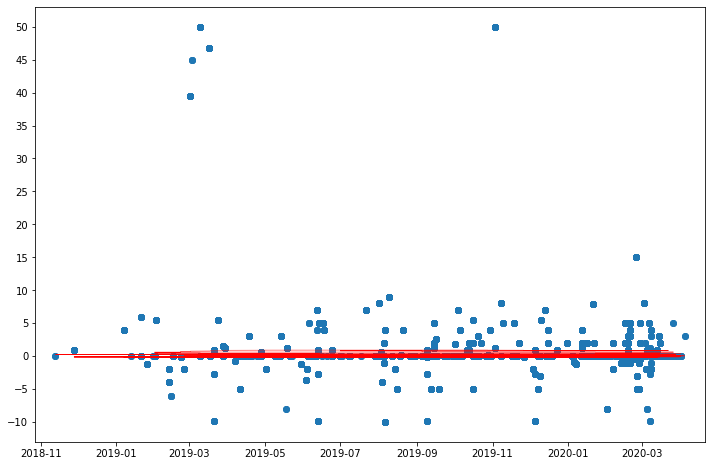

In [1966]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(figsize=(12,8))

data = loess_df[["end_date", "spread"]]
data = pd.concat((data, loess_df_1[["end_date", "spread"]])).reset_index(drop=True)
    
dates = pd.to_datetime(data.end_date)

data['spread'] = data['spread'].apply(lambda x: number(x))
data['spread'] = data['spread'].astype(float)

loess_res = sm.nonparametric.lowess(data.spread.values, dates, frac=0.2, it=50)

axes.scatter(dates, data["spread"])
axes.plot(dates, loess_res[:,1], color='r', lw = 0.5)
axes.yaxis.get_major_locator().set_params(nbins=20)
#axes.yaxis.set_major_formatter(FuncFormatter(edit_tick_label))
axes.grid(False, axis='y')
axes.margins(0, .05)

In [1967]:
loess_res[-7:,1].mean()

0.2527071131139472

In [1968]:
trends = []
for i,group in kmeans_groups:
    data = group[["end_date", "spread"]]
    data = pd.concat((data, polls[["end_date", "spread"]]))
    
    dates = pd.DatetimeIndex(data.end_date).asi8
    
    data['spread'] = data['spread'].apply(lambda x: number(x))
    data['spread'] = data['spread'].astype(float)

    loess_res = sm.nonparametric.lowess(data.spread.values, dates, frac=.1, it=3)
    
    states = group.state.unique()
    
    for state in states:
        trends.append([state, loess_res[-7:,1].mean()])

/Users/siddhipatel/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


In [1969]:
trends

[['Wisconsin', 1.047401483401183],
 ['Kansas', 1.047401483401183],
 ['Maine', 1.047401483401183],
 ['Iowa', 1.047401483401183],
 ['Pennsylvania', 1.047401483401183],
 ['New Hampshire', 1.047401483401183],
 ['North Dakota', 1.047401483401183],
 ['Minnesota', 1.047401483401183],
 ['Alaska', 1.047401483401183],
 ['Utah', 1.047401483401183],
 ['Washington', nan],
 ['New York', nan],
 ['Colorado', nan],
 ['Virginia', nan],
 ['New Jersey', nan],
 ['Delaware', nan],
 ['Michigan', 1.0676767755125651],
 ['Arizona', 1.0676767755125651],
 ['Ohio', 1.0676767755125651],
 ['North Carolina', 1.0676767755125651],
 ['South Carolina', 1.0676767755125651],
 ['New Mexico', 1.0676767755125651],
 ['Nevada', 1.0676767755125651],
 ['Georgia', 1.0676767755125651],
 ['Mississippi', 1.0676767755125651],
 ['Alabama', 1.0676767755125651],
 ['Tennessee', 1.0676767755125651],
 ['Missouri', 1.0676767755125651],
 ['Oklahoma', 1.0676767755125651],
 ['Kentucky', 1.0676767755125651],
 ['Massachusetts', nan],
 ['Florida',

In [603]:
#skip the step with time adjustments bc a bitch don't got time

## Snapshot

In [1970]:
state_polls.name = "poll"
state_polls

state      pollster                                 
Alabama    Mason-Dixon Polling & Research Inc.  2322    0.032710
                                                2323    0.032710
                                                2324    0.032710
                                                2325    0.032710
                                                2326    0.032710
                                                          ...   
Wisconsin  Zogby Interactive/JZ Analytics       2627    0.000037
                                                2628    0.000037
                                                2629    0.000037
                                                2630    0.000037
                                                2631    0.000037
Name: poll, Length: 1627, dtype: float64

In [1971]:
state_polls = state_polls.reset_index()
state_polls.state = state_polls.state.replace(states_abbrev_dict)

In [1972]:
#trends.name = "poll"
trends = pd.DataFrame(trends).set_index(0)

In [1973]:
trends = trends.reset_index()
trends["Pollster"] = "National"
trends

,0,1,Pollster
0,Wisconsin,1.047401,National
1,Kansas,1.047401,National
2,Maine,1.047401,National
3,Iowa,1.047401,National
4,Pennsylvania,1.047401,National
5,New Hampshire,1.047401,National
6,North Dakota,1.047401,National
7,Minnesota,1.047401,National
8,Alaska,1.047401,National
9,Utah,1.047401,National


In [1974]:
polls = pd.concat((state_polls, trends))
polls

,state,pollster,level_2,poll,0,1,Pollster
0,Alabama,Mason-Dixon Polling & Research Inc.,2322.0,0.03271,NaN,NaN,NaN
1,Alabama,Mason-Dixon Polling & Research Inc.,2323.0,0.03271,NaN,NaN,NaN
2,Alabama,Mason-Dixon Polling & Research Inc.,2324.0,0.03271,NaN,NaN,NaN
3,Alabama,Mason-Dixon Polling & Research Inc.,2325.0,0.03271,NaN,NaN,NaN
4,Alabama,Mason-Dixon Polling & Research Inc.,2326.0,0.03271,NaN,NaN,NaN
...,...,...,...,...,...,...,...
29,NaN,NaN,NaN,NaN,Kentucky,1.067677,National
30,NaN,NaN,NaN,NaN,Massachusetts,NaN,National
31,NaN,NaN,NaN,NaN,Florida,1.345456,National
32,NaN,NaN,NaN,NaN,California,1.345456,National
